In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.special as special
from scipy.signal import convolve2d
import cupy as cp
import time
import os

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.602e-19
phi0 = h/(2*e)
phi0bar = phi0/(2*np.pi)
gap = 0.00017*e # from Kittel
Zq = phi0bar/(2*e)
kb = 1.38e-23

# Data vs phiext

In [2]:
# load data vs phiext

# folder = os.path.join(os.getcwd(), 'data_240325_ng0p25')
folder = os.path.join(os.getcwd(), 'data_240402_ng0')
amp = np.load(os.path.join(folder, 'amplitude_data.npy'))
pha = np.load(os.path.join(folder, 'phase_data.npy'))
dc = np.load(os.path.join(folder, 'dc_coord.npy'))
freq = np.load(os.path.join(folder, 'spec_coord.npy'))
phi_exp = (dc-5.625)/(5.65+3.65)*np.pi
# points_dc, points_freq = np.load(os.path.join(folder, 'manual_points.npy'))
# points_phi = (points_dc-5.625)/(5.65+3.65)*np.pi
 
Ns_dc = 1
Ns_freq = 3
amp_s = convolve2d(amp, np.ones((Ns_dc,Ns_freq))/Ns_dc/Ns_freq, mode='same')

def plotter(ax, folder, file, ng, color='w', from_state=[0,1], ncut=15, Nfold=50):
    folder = os.path.join(folder, file)
    # folder = os.path.join('C:\\Users\\Marius\\Google Drive\\HQC\\simulations\\protected\\KitemonB_20240208', file)
    name = 'vs_phiext_ng_%s.npy'%(ng)
    ngs, phiexts, lvls, _ = np.load(os.path.join(folder,name), allow_pickle=True)
    ls = ['-', '--', ':']
    phiext_fold = np.concatenate((-2*np.pi-phiexts[:Nfold][::-1], phiexts, -phiexts[-Nfold:][::-1]))
    for ss, s0 in enumerate(from_state):
        nrjs = lvls - lvls[:,s0][:,None]
        nrjs_fold = np.concatenate((nrjs[:Nfold][::-1], nrjs, nrjs[-Nfold:][::-1]))
        for ll in range(ncut):
            _ = ax.plot(phiext_fold, nrjs_fold[:,ll].real, c=color, ls=ls[ss], lw=1)


In [9]:
def cpu(x):
    if cp.get_array_module(x).__name__ == 'cupy':
        return x.get()
    else:
        return x


def gpu(x):
    if cp.get_array_module(x).__name__ == 'numpy':
        return x
    else:
        return cp.array(x)


def parser(E, precision=2, point='p'):
    E = cpu(E)
    E_int = int(E)
    E_dec = int(np.round((E-np.floor(E_int))*10**precision))
    E_int_str = str(E_int)
    E_dec_str = str(E_dec)
    for ii in range(1, precision):
        if E_dec < 10 ** (precision - ii):
            E_dec_str = '0' + E_dec_str
    Eparsed = '%s%s%s' % (E_int_str, point, E_dec_str)
    return Eparsed


def namer(EC, EJ, EL, ECs, precisions=[2,2,2,2]):
    EC = parser(cpu(EC), precision=precisions[0])
    EJ = parser(cpu(EJ), precision=precisions[1])
    EL = parser(cpu(EL), precision=precisions[2])
    ECs = parser(cpu(ECs), precision=precisions[3])
    name = 'EC%s_EJ%s_EL%s_ECS%s' % (EC, EJ, EL, ECs)
    return name


def titler(EC, EJ, EL, ECs, precisions=[2,2,2,2]):
    EC = parser(cpu(EC), precision=precisions[0], point='.')
    EJ = parser(cpu(EJ), precision=precisions[1], point='.')
    EL = parser(cpu(EL), precision=precisions[2], point='.')
    ECs = parser(cpu(ECs), precision=precisions[3], point='.')
    title = r'$E_C=$%sGHz, $E_J=$%sGHz, $E_L=$%sGHz, $E_{Cs}=$%sMHz' % (EC, EJ, EL, ECs)
    return title


bare_params = [3.7, cp.array(5.01), 0.41, 0.002]
print(namer(*bare_params))
print(titler(*bare_params))

EC3p70_EJ5p01_EL0p41_ECS0p00
$E_C=$3.70GHz, $E_J=$5.01GHz, $E_L=$0.41GHz, $E_{Cs}=$0.00MHz


Text(0.5, 1.0, '$E_C=$2.56GHz, $E_J=$2.90GHz, $E_L=$0.41GHz, $E_{Cs}=$0.10MHz')

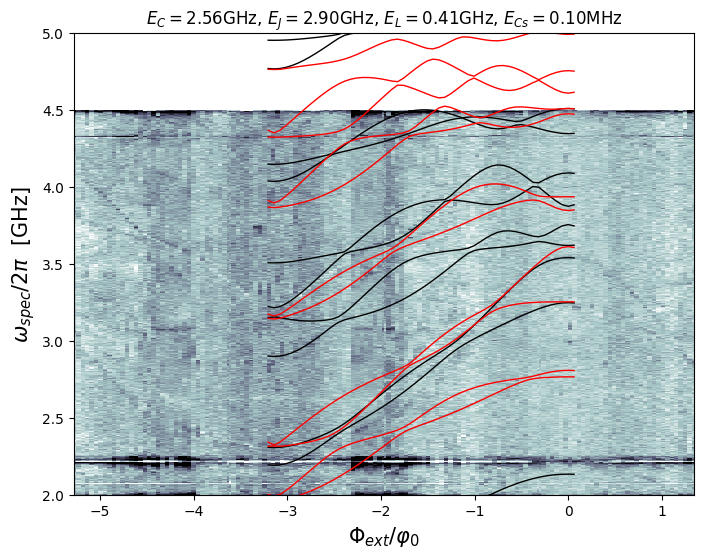

In [14]:
# plot data vs phiext

fig, ax = plt.subplots(figsize=(8,6))
vmin = np.quantile(amp_s, 0.005)
vmax = np.quantile(amp_s, 0.997)
im = ax.pcolormesh(phi_exp, freq/1e9-0, amp_s.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
# fig.colorbar(im, ax=ax)
# ax.plot(points_phi, points_freq/1e9, color = 'green', ls='', ms=4, alpha=1, marker='+')

ng = '0p25'
from_state = [0, 1]

# bare_params = [2.84, 3.22, 0.41, 0.11]   # EC, EJ, EL, ECshunt
# folder = os.path.join(os.getcwd(), namer(*bare_params))
# name = 'EC2p56_EJ2p90_EL0p41_ECS0p110_asym5_CuPy'
# plotter(ax, folder, name, ng=ng, from_state=from_state, color='k')

bare_params = [2.56, 2.90, 0.41, 0.1]   # EC, EJ, EL, ECshunt
folder = os.getcwd()
from_state = [0]
name = namer(*bare_params)+'_asym5_CuPy'
ng = '0p00'
plotter(ax, folder, name, ng=ng, from_state=from_state, color='k', Nfold=2)
ng = '0p50'
plotter(ax, folder, name, ng=ng, from_state=from_state, color='r', Nfold=2)

ax.set_ylim([2,5])
ax.set_xlim([phi_exp[0], phi_exp[-1]])

#ax.set_xlim([-3.5,-2.8])
#ax.set_ylim([3, 3.5])

ax.set_ylabel(r'$\omega_{spec}/2\pi$  [GHz]', fontsize=15)
ax.set_xlabel(r'$\Phi_{ext}/\varphi_0$', fontsize=15)
ax.set_title(titler(*bare_params))
# plt.savefig('fig')


In [15]:
np.sqrt(8*2.84*2.9)

8.117142354301789

(-5.278213463692528, 1.477899769833908)

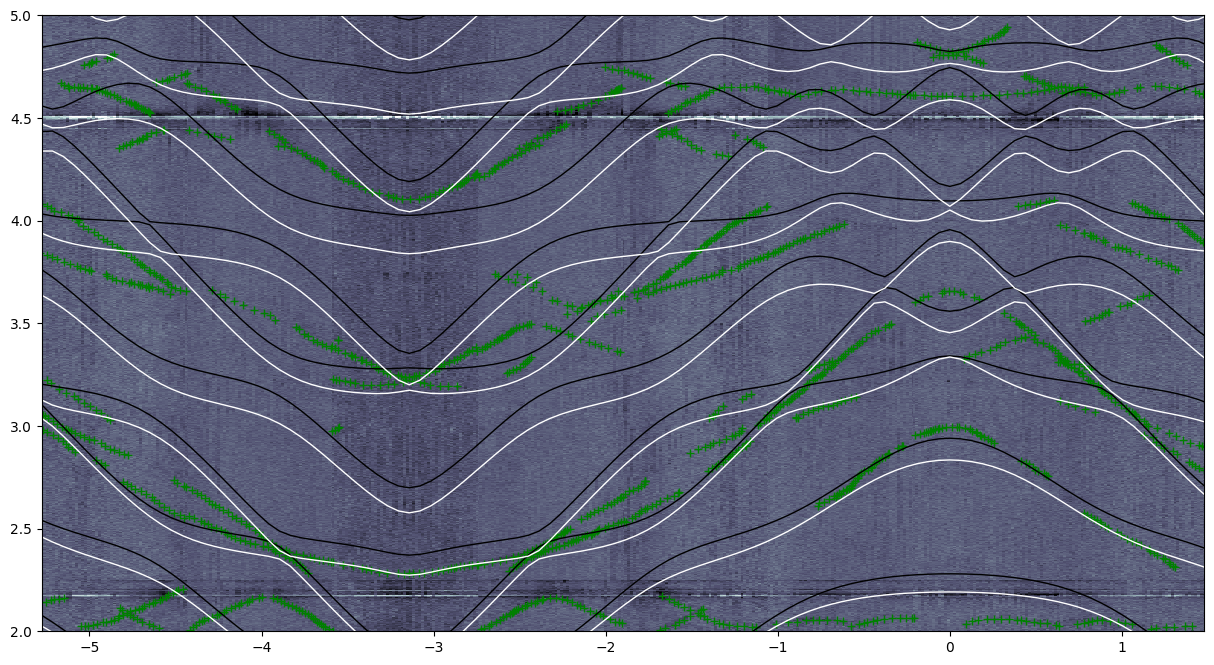

In [4]:
# compare two single sweeps

fig, ax = plt.subplots(figsize=(15,8))
vmin = np.quantile(amp_s, 0.0001)
vmax = np.quantile(amp_s, 0.9999)
ax.pcolormesh(phi_exp, freq/1e9-0, amp_s.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
ax.scatter(points_phi, points_freq/1e9, color = 'green', linewidths=1, alpha=1, marker='+')

folder = os.getcwd()
ng = '0p25'
from_state = [0]

EC = 2.15
EJ = 4.25
EL = 0.40
ECs = 0.12
name = namer(EC, EJ, EL, ECs, precisions=[2,2,2,2])+'_asym5_CuPy'
plotter(ax, folder, name, ng=ng, from_state=from_state, color='k')

EC = 2.15
EJ = 4.25
EL = 0.40
ECs = 0.11
name = namer(EC, EJ, EL, ECs, precisions=[2,2,2,2])+'_asym5_CuPy'
plotter(ax, folder, name, ng=ng, from_state=from_state, color='w')

ax.set_ylim([2,5])
ax.set_xlim([phi_exp[0], phi_exp[-1]])

#ax.set_xlim([-3.5,-2.8])
#ax.set_ylim([3, 3.5])


EC2p84_EJ3p22_EL0p38_ECS0p100_asym5_CuPy
EC2p84_EJ3p22_EL0p42_ECS0p100_asym5_CuPy
EC2p84_EJ3p22_EL0p46_ECS0p100_asym5_CuPy


(-5.278213463692528, 1.477899769833908)

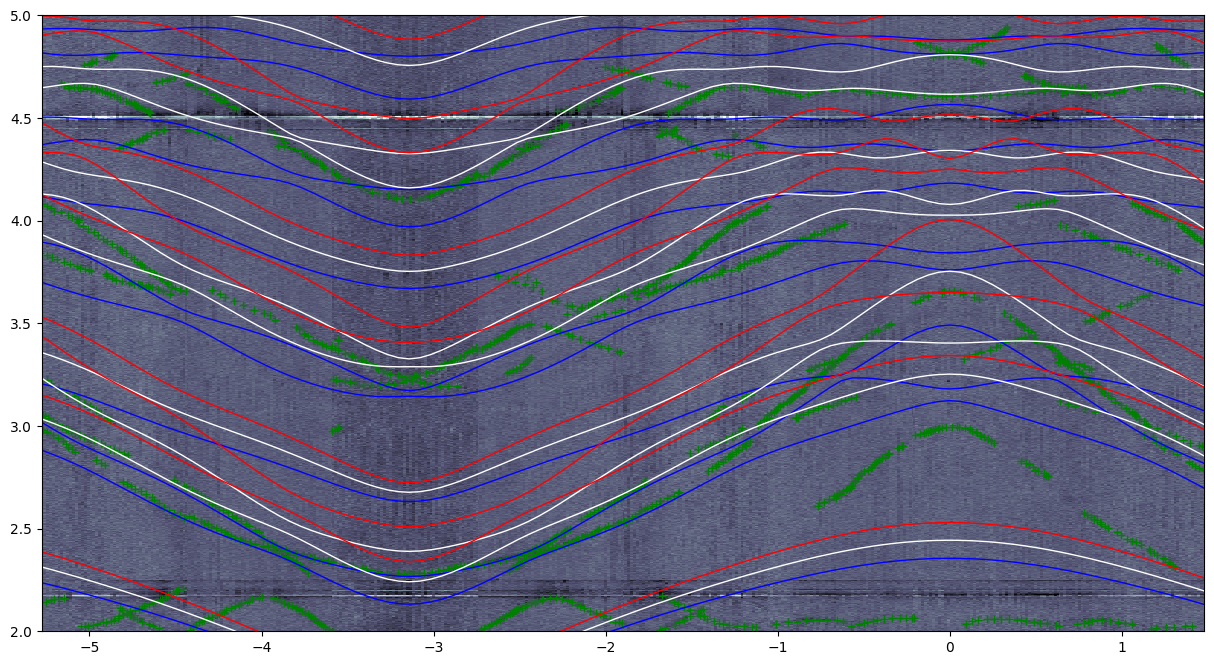

In [8]:
# compare multi-parameter sweep

fig, ax = plt.subplots(figsize=(15,8))
vmin = np.quantile(amp_s, 0.0001)
vmax = np.quantile(amp_s, 0.9999)
ax.pcolormesh(phi_exp, freq/1e9-0, amp_s.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
ax.scatter(points_phi, points_freq/1e9, color = 'green', linewidths=1, alpha=1, marker='+')

ng = '0p25'
from_state = [0]

bare_params = [2.84, 3.22, 0.42, 0.1]   # EC, EJ, EL, ECshunt
folder = os.path.join(os.getcwd(), namer(*bare_params))

variations = [0.1, 0.1, 0.1, 0.1]   # wplasma, EJ/EC, EL, ECshunt
vv = 2

variation = variations[vv]
color = ['b', 'w', 'r']
for ss, scale in enumerate([1-variation, 1, 1+variation]):
    EC, EJ, EL, ECs = bare_params
    if vv == 0: ## 
        EC *= scale
        EJ *= scale
    elif vv == 1: # blue ## white
        EC /= np.sqrt(scale)
        EJ *= np.sqrt(scale)
    elif vv == 2: ## white
        EL *= scale
    elif vv == 3: # blue ## 
        ECs *= scale
    name = namer(EC, EJ, EL, ECs, precisions=[2,2,2,3])+'_asym5_CuPy'
    print(name)
    plotter(ax, folder, name, ng=ng, from_state=from_state, color=color[ss])

ax.set_ylim([2,5])
ax.set_xlim([phi_exp[0], phi_exp[-1]])

#ax.set_xlim([-3.5,-2.8])
#ax.set_ylim([3, 3.5])


In [18]:
EC = 2.26
EJ = 4.06
EL = 0.41
ECs = 0.11

scale = 0.9
print(EC*scale, EJ*scale)

scale = 1.1
print(EC/np.sqrt(scale), EJ*np.sqrt(scale))

2.034 3.654
2.1548254516950385 4.258163923570815


In [61]:
5.01/3.7

1.354054054054054

In [70]:
3.7*np.sqrt(0.9)

3.510128202786901

In [69]:
5.01/np.sqrt(0.9)

5.281003692481193

In [80]:
100*11/3600*4

1.2222222222222223

In [81]:
x= 0.9
print(3.7*np.sqrt(x))
print(5.01/np.sqrt(x))

3.510128202786901
5.281003692481193


# Data vs ng

In [32]:
# load data vs ng

folder = os.path.join(os.getcwd(), 'data_240402_phi0')
amp = np.load(os.path.join(folder, 'amplitude_data.npy'))
pha = np.load(os.path.join(folder, 'phase_data.npy'))
ng = np.load(os.path.join(folder, 'ng_coord.npy'))
freq = np.load(os.path.join(folder, 'spec_coord.npy'))
# points_dc, points_freq = np.load(os.path.join(folder, 'manual_points.npy'))
# points_phi = (points_dc-5.625)/(5.65+3.65)*np.pi
 
Ns_dc = 1
Ns_freq = 1
amp_s = convolve2d(amp, np.ones((Ns_dc,Ns_freq))/Ns_dc/Ns_freq, mode='same')

def plotter(ax, folder, file, ng, color='w', from_state=[0,1], ncut=15, Nfold=50):
    folder = os.path.join(folder, file)
    # folder = os.path.join('C:\\Users\\Marius\\Google Drive\\HQC\\simulations\\protected\\KitemonB_20240208', file)
    name = 'vs_phiext_ng_%s.npy'%(ng)
    ngs, phiexts, lvls, _ = np.load(os.path.join(folder,name), allow_pickle=True)
    ls = ['-', '--', ':']
    phiext_fold = np.concatenate((-2*np.pi-phiexts[:Nfold][::-1], phiexts, -phiexts[-Nfold:][::-1]))
    for ss, s0 in enumerate(from_state):
        nrjs = lvls - lvls[:,s0][:,None]
        nrjs_fold = np.concatenate((nrjs[:Nfold][::-1], nrjs, nrjs[-Nfold:][::-1]))
        for ll in range(ncut):
            _ = ax.plot(phiext_fold, nrjs_fold[:,ll].real, c=color, ls=ls[ss], lw=1)


Text(0.5, 1.0, '$E_C=$2.56GHz, $E_J=$2.90GHz, $E_L=$0.41GHz, $E_{Cs}=$0.10MHz')

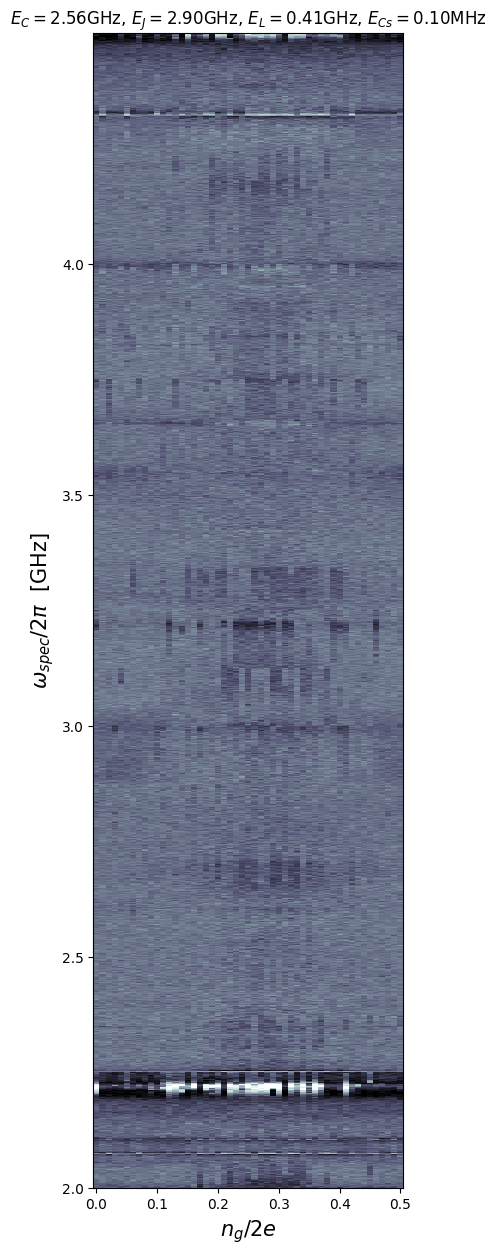

In [38]:
# plot data vs ng

fig, ax = plt.subplots(figsize=(4,15))
vmin = np.quantile(amp_s, 0.001)
vmax = np.quantile(amp_s, 0.999)
im = ax.pcolormesh(dc, freq/1e9-0, amp_s.T, shading='nearest', vmin=vmin, vmax=vmax, cmap='bone')
# fig.colorbar(im, ax=ax)
# ax.plot(points_phi, points_freq/1e9, color = 'green', ls='', ms=4, alpha=1, marker='+')

bare_params = [2.56, 2.90, 0.41, 0.1]   # EC, EJ, EL, ECshunt
folder = os.getcwd()
from_state = [0]
name = namer(*bare_params)+'_asym5_CuPy'
ng = '0p00'
# plotter(ax, folder, name, ng=ng, from_state=from_state, color='k', Nfold=2)


# ax.set_ylim([2,5])
# ax.set_xlim([phi_exp[0], phi_exp[-1]])

#ax.set_xlim([-3.5,-2.8])
#ax.set_ylim([3, 3.5])

ax.set_ylabel(r'$\omega_{spec}/2\pi$  [GHz]', fontsize=15)
ax.set_xlabel(r'$n_g/2e$', fontsize=15)
ax.set_title(titler(*bare_params))
# plt.savefig('fig')
